Found 14000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.
Classes: {'notStudying': 0, 'studying': 1}
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                             

None
Epoch 1/25
437/437 [==============================] - ETA: 0s - loss: 0.2318 - accuracy: 0.9007
Epoch 1: val_loss improved from inf to 0.37046, saving model to studying_Mobilenet.h5
437/437 [==============================] - 116s 263ms/step - loss: 0.2318 - accuracy: 0.9007 - val_loss: 0.3705 - val_accuracy: 0.8484 - lr: 0.0010
Epoch 2/25


c:\Users\tlgus\anaconda3\envs\flask\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


437/437 [==============================] - ETA: 0s - loss: 0.1210 - accuracy: 0.9543
Epoch 2: val_loss did not improve from 0.37046
437/437 [==============================] - 115s 262ms/step - loss: 0.1210 - accuracy: 0.9543 - val_loss: 0.6135 - val_accuracy: 0.7853 - lr: 0.0010
Epoch 3/25
437/437 [==============================] - ETA: 0s - loss: 0.0927 - accuracy: 0.9682
Epoch 3: val_loss did not improve from 0.37046
437/437 [==============================] - 115s 263ms/step - loss: 0.0927 - accuracy: 0.9682 - val_loss: 0.5130 - val_accuracy: 0.8337 - lr: 0.0010
Epoch 4/25
437/437 [==============================] - ETA: 0s - loss: 0.0739 - accuracy: 0.9728
Epoch 4: val_loss did not improve from 0.37046
437/437 [==============================] - 115s 263ms/step - loss: 0.0739 - accuracy: 0.9728 - val_loss: 0.8954 - val_accuracy: 0.7885 - lr: 0.0010
Epoch 5/25
437/437 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.9755
Epoch 5: val_loss did not improve from 0.3

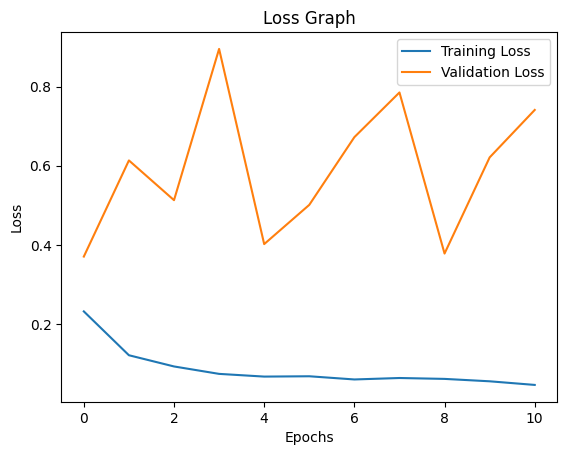

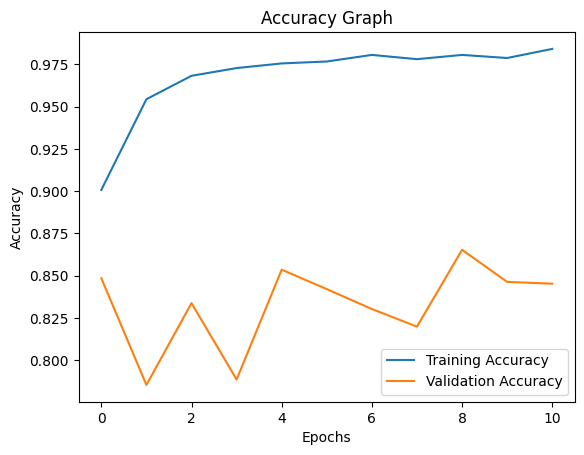

In [3]:
import os
import zipfile
import numpy as np
import tensorflow 
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import shutil

train_data_directory = 'train_data'
validation_data_directory = 'validation_data'

train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

batch_size = 20
image_size = (224,224)

train_generator = train_datagen.flow_from_directory(
    train_data_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # 검증 데이터는 섞지 않음
)

# 클래스 인덱스 확인
print("Classes:", train_generator.class_indices)

mobileNet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in mobileNet.layers:
    layer.trainable = False

num_classes = 2  # studying / NotStudying

def addModel(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)  # 첫 번째 dropout 층 (예: 50%의 뉴런을 비활성화)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dropout(0.3)(top_model)  # 두 번째 dropout 층 (예: 30%의 뉴런을 비활성화)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)  # 세 번째 dropout 층 (예: 20%의 뉴런을 비활성화)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)  # 네 번째 dropout 층 (예: 20%의 뉴런을 비활성화)
    top_model = Dense(num_classes, activation='softmax')(top_model)  # 마지막 분류 layer
    return top_model



head = addModel(mobileNet, num_classes)
model = Model(inputs=mobileNet.input, outputs=head)
print(model.summary())

checkpoint = ModelCheckpoint(
    'studying_Mobilenet.h5',
    monitor='val_loss',
    mode='min',  # 수정됨
    save_best_only=True,
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,  # 필요에 따라 조정
    patience=10,
    verbose=1,
    restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',  
    verbose=1,
    factor=0.2,
    min_lr=0.001
)

callbacks = [earlystop, checkpoint, learning_rate_reduction]

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

# 실제 데이터셋 크기에 맞게 train_samples 및 val_samples 수정
train_samples = 14000
val_samples = 6000

epochs = 25

history = model.fit(
    train_generator,
    steps_per_epoch=train_samples // 32,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=val_samples // 32
)

# 손실 그래프
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 정확도 그래프
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# 학습된 모델 불러오기
model = load_model('studying_Mobilenet.h5')

# 이미지 데이터를 로드하고 전처리하는 함수
def load_and_preprocess_image(image_path, target_size):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # 이미지를 [0, 1] 범위로 정규화
    img = tf.expand_dims(img, axis=0)  # 배치 차원을 추가
    return img

# 테스트 이미지 경로
test_image_path = 'test/test_data_folder/test.jpg'

# 이미지를 불러오고 전처리
image = load_and_preprocess_image(test_image_path, target_size=(224, 224))

# 모델에 이미지를 입력하여 예측 수행
predictions = model.predict(image)
# 예측 결과 출력
class_names = ["notStudying", "studying"]
for i in range(len(class_names)):
    class_name = class_names[i]
    probability = predictions[0][i] * 100
    print(f'클래스 "{class_name}" 확률: {probability:.2f}%')

# 가장 높은 확률을 가진 클래스 선택
predicted_class = class_names[predictions.argmax()]
print(f'이미지는 "{predicted_class}" 클래스에 속합니다.')

1/1 [==============================] - 0s 336ms/step
클래스 "notStudying" 확률: 100.00%
클래스 "studying" 확률: 0.00%
이미지는 "notStudying" 클래스에 속합니다.


In [ ]:
print(flow_from_directory.help)